In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Clean Data from May 27 to June 23 

In [2]:
## Setup

In [3]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mta_importer as mp


from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

In [4]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 0.20.2
Numpy version: 1.12.1


In [5]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('display.precision',3)

In [73]:
# read data

#df = mp.mta_selector('06-03-17','06-30-17')
filelist = ['http://web.mta.info/developers/data/nyct/turnstile/turnstile_170624.txt',
            'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170617.txt',
            'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170610.txt',
            'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt'
           ]
for file_name in filelist:
    if file_name == filelist[0]:
        df = pd.read_csv(file_name)
    else:
        df = df.append(pd.read_csv(file_name))
df.head()



,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513


In [74]:
cols = ['control_area', 'unit', 'scp', 'station', 'line_name',\
        'division', 'date', 'time', 'desc','cum_entries', 'cum_exits']

df.columns = cols
df.head()

,control_area,unit,scp,station,line_name,division,date,time,desc,cum_entries,cum_exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513


In [75]:
df = df.reset_index(drop=True)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788214 entries, 0 to 788213
Data columns (total 11 columns):
control_area    788214 non-null object
unit            788214 non-null object
scp             788214 non-null object
station         788214 non-null object
line_name       788214 non-null object
division        788214 non-null object
date            788214 non-null object
time            788214 non-null object
desc            788214 non-null object
cum_entries     788214 non-null int64
cum_exits       788214 non-null int64
dtypes: int64(2), object(9)
memory usage: 66.1+ MB


In [77]:
# check contents of variables
print(df.shape)
print(df.desc.value_counts())
print(df.division.value_counts())

(788214, 11)
REGULAR       785406
RECOVR AUD      2808
Name: desc, dtype: int64
IRT    287131
IND    282446
BMT    160816
PTH     50524
SRT      5607
RIT      1690
Name: division, dtype: int64


In [78]:
# check turnstile's smallest set of uniquely identifiable variables
# result: a tunstile is unique by control area, scp and station

print(df[['control_area','scp','station']].drop_duplicates().shape)
print(df[['scp','station']].drop_duplicates().shape)
print(df[['control_area','scp','station','unit']].drop_duplicates().shape)


(4710, 3)
(4158, 2)
(4710, 4)


In [79]:
# add datetime variable
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format = '%m/%d/%Y %H:%M:%S')
df.datetime.describe()

count                  788214
unique                  51940
top       2017-06-20 20:00:00
freq                     2421
first     2017-05-27 00:00:00
last      2017-06-23 23:59:58
Name: datetime, dtype: object

In [81]:
# add shifted data
df[['shift_cum_entries','shift_cum_exits', 'shift_datetime']] = \
df.sort_values(['control_area','scp','station','datetime'])\
.groupby(['control_area','scp', 'station'])[['cum_entries','cum_exits','datetime']]\
.shift(1)

df['entries'] = df['cum_entries'] - df['shift_cum_entries']
df['exits'] = df['cum_exits'] - df['shift_cum_exits']
df.head()
#df.iloc[-50:]
#df[['entries','exits']].to_csv('example.csv')

,control_area,unit,scp,station,line_name,division,date,time,desc,cum_entries,cum_exits,datetime,shift_cum_entries,shift_cum_exits,shift_datetime,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317,2017-06-17 00:00:00,"6,224,607.00","2,107,297.00",2017-06-16 20:00:00,209.00,20.00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322,2017-06-17 04:00:00,"6,224,816.00","2,107,317.00",2017-06-17 00:00:00,34.00,5.00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352,2017-06-17 08:00:00,"6,224,850.00","2,107,322.00",2017-06-17 04:00:00,35.00,30.00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452,2017-06-17 12:00:00,"6,224,885.00","2,107,352.00",2017-06-17 08:00:00,120.00,100.00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513,2017-06-17 16:00:00,"6,225,005.00","2,107,452.00",2017-06-17 12:00:00,243.00,61.00


In [82]:
df[['entries','exits']].describe()

,entries,exits
count,"783,504.00","783,504.00"
mean,"6,325.00","4,147.11"
std,"2,939,348.53","2,483,152.29"
min,"-101,036,140.00","-33,597,403.00"
25%,10.00,8.00
50%,78.00,53.00
75%,248.00,168.00
max,"1,621,023,313.00","2,038,811,878.00"


In [83]:
# describe negative/zero values
print('percentage of negative entries:', "{0:.3f}%".format(df[df.entries < 0].shape[0]/df.shape[0]))
print('percentage of zero entries:', "{0:.3f}%".format(df[df.entries == 0].shape[0]/df.shape[0]))
print('percentage of negative exits:', "{0:.3f}%".format(df[df.exits < 0].shape[0]/df.shape[0]))
print('percentage of zero entries:', "{0:.3f}%".format(df[df.exits == 0].shape[0]/df.shape[0]))

# - since negative number's percentage is small, we can take a look at the negative numbers to tell how the numbers are wrong
# - the zero recordings are likely to be from the station closing, or resetting of number
# - we can manually get a sense the outlieres of positive numbers by eyeballing the numbers


percentage of negative entries: 0.008%
percentage of zero entries: 0.150%
percentage of negative exits: 0.006%
percentage of zero entries: 0.147%


### Process negative numbers

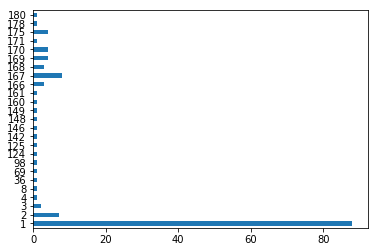

In [84]:
df[df.entries < 0].groupby(['station','control_area','scp'])['entries'].count().value_counts().sort_index().plot('barh')

# vertical axis is numbers of negative entries a turnstile has
# horizental is the count of the number of turnstile with a specific vertical value



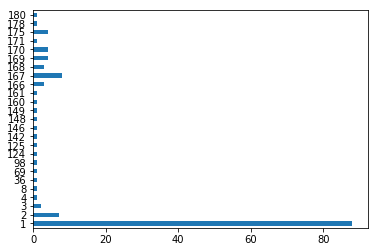

In [85]:
df[df.entries < 0].groupby(['station','control_area','scp'])['exits'].count().value_counts().sort_index().plot('barh')
# vertical axis is numbers of negative exits a turnstile has
# horizental is the count of the number of turnstile with a specific vertical value


In [86]:
# findings: 
# the negative negative entries/eixts either happen singularly (peak in 1), or happen for all periods (peaks in multiples of 41-45)

# for now, just process all negative numbers as null values 
# will need to refine the process later 

df.loc[df.entries < 0,'entries'] = np.nan
df.loc[df.exits < 0,'exits'] = np.nan


In [87]:
df[['entries','exits']].describe()

,entries,exits
count,"777,103.00","778,461.00"
mean,"6,883.06","4,360.30"
std,"2,945,486.56","2,490,575.33"
min,0.00,0.00
25%,11.00,9.00
50%,80.00,54.00
75%,250.00,169.00
max,"1,621,023,313.00","2,038,811,878.00"


### Process Outliers

In [89]:
# investigate outliers for entries

df[df.entries > 5000][['entries','cum_entries','shift_cum_entries']].sort_values('entries')

# it seems that there is a discontunity of data from 12K-ish to more than 60K in entries
# for now, process all entries numbers larger than 12K as null values


,entries,cum_entries,shift_cum_entries
82991,"6,316.00",13576291,"13,569,975.00"
83667,"7,155.00",2217322,"2,210,167.00"
83710,"8,807.00",2619718,"2,610,911.00"
83624,"9,187.00",31466,"22,279.00"
702907,"10,352.00",11462,"1,110.00"
702905,"10,630.00",11187,557.00
702910,"11,552.00",13704,"2,152.00"
505315,"65,925.00",92324,"26,399.00"
314048,"119,169.00",121167,"1,998.00"
116212,"150,679.00",258382,"107,703.00"


In [91]:
# investigate outliers for exits


#df[df.exits > 4000].sort_values('exits')
df[df.exits > 5000][['exits','cum_exits','shift_cum_exits']].sort_values('exits')

# it seems that there is a discontunity of data from 15K-ish to more than 27K in entries
# for now, process all exits numbers larger than 15K as null values

,exits,cum_exits,shift_cum_exits
48964,"5,512.00",57967162,"57,961,650.00"
83667,"5,524.00",1533570,"1,528,046.00"
505315,"5,782.00",7364,"1,582.00"
83117,"6,712.00",15135629,"15,128,917.00"
702905,"10,066.00",10105,39.00
83159,"10,486.00",23168999,"23,158,513.00"
83624,"11,438.00",35462,"24,024.00"
702907,"11,789.00",12052,263.00
702910,"12,071.00",12443,372.00
83368,"14,906.00",4964291,"4,949,385.00"


In [92]:
# process outliers
df.loc[df.entries > 12000,'entries'] = np.nan
df.loc[df.exits > 15000,'exits'] = np.nan

In [93]:
df[['entries','exits']].describe()


,entries,exits
count,"777,084.00","778,444.00"
mean,180.29,138.45
std,257.67,232.70
min,0.00,0.00
25%,11.00,9.00
50%,80.00,54.00
75%,250.00,169.00
max,"11,552.00","14,906.00"


In [98]:
df = df.sort_values(['control_area','scp','station','datetime'])
df.head()
df.to_csv('../data/month_data.csv')